# Fine-Tuning `google/flan-t5-large` with QLoRA

This notebook demonstrates how to fine-tune the `google/flan-t5-large` (770M parameters) model on a custom classification task. It is specifically optimized for consumer GPUs with limited VRAM (e.g., 6-8GB) by using the **QLoRA (Quantized Low-Rank Adaptation)** technique.


## 1. Environment Setup

In [1]:
!pip install -q --upgrade transformers accelerate peft bitsandbytes scikit-learn pandas matplotlib seaborn datasets

In [2]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel, # We need the generic AutoModel for our custom class
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig,
)
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput

c:\Users\zrhrissi\Documents\Phd models\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

In [3]:
MODEL_NAME = "google/flan-t5-large"
DATASET_PATH = "dataset/cleaned_dataset.csv"
OUTPUT_DIR = "./flan-t5-large-qlora-tuned"

LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = ["q", "k", "v", "o"]

BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 2e-4
NUM_EPOCHS = 5
MAX_SEQ_LENGTH = 512

## 3. Custom Model Definition & Helper Functions

To resolve incompatibilities, we create a custom model class. This ensures the base T5 model is correctly quantized **before** we add a classification head and apply LoRA adapters.

In [4]:
class T5ForSequenceClassification(torch.nn.Module):
    def __init__(self, model_name, num_labels, quantization_config):
        super(T5ForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        
        # Load the base T5 model using AutoModel
        self.t5 = AutoModel.from_pretrained(
            model_name,
            quantization_config=quantization_config,
            device_map="auto"
        )
        self.config = self.t5.config
        
        # Define the classification head
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # For T5, we use the encoder's output for classification tasks
        encoder_outputs = self.t5.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Perform mean pooling on the encoder's last hidden state
        last_hidden_state = encoder_outputs.last_hidden_state
        pooled_output = last_hidden_state.mean(dim=1)
            
        # Pass the pooled output through the classification head
        logits = self.classifier(self.dropout(pooled_output))
        
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        return SequenceClassifierOutput(loss=loss, logits=logits)

def setup_environment():
    if not torch.cuda.is_available():
        print("❌ No GPU detected. QLoRA requires a GPU. Exiting.")
        sys.exit(1)
    device = torch.device("cuda")
    has_bf16_support = torch.cuda.is_bf16_supported()
    print(f"✅ GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"✅ BFloat16 Support: {'Yes' if has_bf16_support else 'No (will use Float16)'}")
    torch.cuda.empty_cache()
    return device, has_bf16_support

def load_and_prepare_data(dataset_path):
    print(f"\n📂 Loading dataset from '{dataset_path}'...")
    try:
        df = pd.read_csv(dataset_path)
    except FileNotFoundError:
        print(f"❌ Dataset not found! Please check the path: {dataset_path}")
        return None, None, None
    df_clean = df[['text', 'label']].copy().dropna()
    train_val_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['label'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['label'])
    print("📈 Data splits created:")
    print(f"   - Training:   {len(train_df)} samples")
    print(f"   - Validation: {len(val_df)} samples")
    print(f"   - Test:       {len(test_df)} samples")
    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df), Dataset.from_pandas(test_df)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

## 4. Model Preparation and QLoRA Configuration

In [5]:
device, has_bf16_support = setup_environment()

print("\n⚙️  Configuring QLoRA for 4-bit quantization...")
compute_dtype = torch.bfloat16 if has_bf16_support else torch.float16
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

print(f"🚀 Loading base model '{MODEL_NAME}' with our custom class...")
model = T5ForSequenceClassification(
    MODEL_NAME,
    num_labels=2,
    quantization_config=quantization_config
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("✨ Applying LoRA adapters to the model...")
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, # We now use SEQ_CLS as our model is a classification model
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=LORA_TARGET_MODULES,
)
model = get_peft_model(model, peft_config)

print("\n🔥 LoRA Model Configuration:")
model.print_trainable_parameters()

✅ GPU detected: NVIDIA GeForce RTX 4050 Laptop GPU
✅ BFloat16 Support: Yes

⚙️  Configuring QLoRA for 4-bit quantization...
🚀 Loading base model 'google/flan-t5-large' with our custom class...
✨ Applying LoRA adapters to the model...

🔥 LoRA Model Configuration:
trainable params: 9,439,234 || all params: 759,692,292 || trainable%: 1.2425


## 5. Training

With the model prepared, we now load and tokenize the datasets and configure the `Trainer`. The `trainer.train()` command will start the fine-tuning process.

In [7]:
train_dataset, val_dataset, test_dataset = load_and_prepare_data(DATASET_PATH)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_SEQ_LENGTH)

if train_dataset:
    print("\n... Tokenizing all datasets ...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    print("📋 Setting up Hugging Face Trainer...")
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        learning_rate=LEARNING_RATE,
        lr_scheduler_type="cosine",
        optim="paged_adamw_8bit",
        fp16=not has_bf16_support,
        bf16=has_bf16_support,
        logging_dir=f"{OUTPUT_DIR}/logs",
        logging_steps=25,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
        remove_unused_columns=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
    )

    print("\n🚀 Starting QLoRA fine-tuning...")
    trainer.train()
    print("✅ Fine-tuning complete!")


📂 Loading dataset from 'dataset/cleaned_dataset.csv'...
📈 Data splits created:
   - Training:   29110 samples
   - Validation: 3235 samples
   - Test:       8087 samples

... Tokenizing all datasets ...


Map: 100%|██████████| 8087/8087 [00:00<00:00, 8286.28 examples/s]


📋 Setting up Hugging Face Trainer...

🚀 Starting QLoRA fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.882000,0.136787,0.963524,0.964522,0.939110,0.991347
2,0.677500,0.158447,0.964142,0.965228,0.937136,0.995056
3,0.324200,0.159893,0.969706,0.970339,0.950771,0.990729
4,0.323000,0.199106,0.965997,0.966867,0.943008,0.991965
5,0.036100,0.197606,0.966615,0.967489,0.943075,0.993201


✅ Fine-tuning complete!


## 6. Final Evaluation

After training, we evaluate the model on the unseen test set to measure its performance.


🧪 Evaluating final model on the unseen test set...



📊 Final Classification Report:
              precision    recall  f1-score   support

 Real Review       0.99      0.95      0.97      4044
 Fake Review       0.95      0.99      0.97      4043

    accuracy                           0.97      8087
   macro avg       0.97      0.97      0.97      8087
weighted avg       0.97      0.97      0.97      8087


📈 Confusion Matrix:


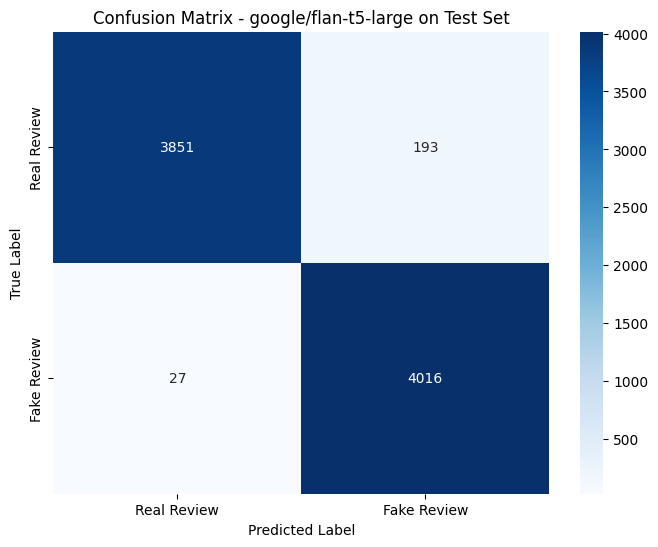

In [8]:
print("\n🧪 Evaluating final model on the unseen test set...")
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("\n" + "="*50)
print("📊 Final Classification Report:")
print("="*50)
print(classification_report(y_true, y_pred, target_names=["Real Review", "Fake Review"]))

print("\n" + "="*50)
print("📈 Confusion Matrix:")
print("="*50)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real Review", "Fake Review"], yticklabels=["Real Review", "Fake Review"])
plt.title(f'Confusion Matrix - {MODEL_NAME} on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [1]:
# Full metrics for test data
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix

# y_true and y_pred should already be defined from previous cells
print('--- Full Classification Report ---')
print(classification_report(y_true, y_pred, target_names=["Real Review", "Fake Review"], digits=4))

print('--- Per-class Precision, Recall, F1, Support ---')
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
for i, label in enumerate(["Real Review", "Fake Review"]):
    print(f"{label}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-score:  {f1[i]:.4f}")
    print(f"  Support:   {support[i]}")

print('--- Overall Metrics ---')
accuracy = accuracy_score(y_true, y_pred)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall:    {weighted_recall:.4f}")
print(f"Weighted F1-score:  {weighted_f1:.4f}")

--- Full Classification Report ---


NameError: name 'y_true' is not defined